In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read(r'C:\Users\Administrator\Desktop\端点检测\lab1\语料\1.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

In [3]:
signal= signal[200:455]

In [5]:
pre_emphasis= 0.98
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

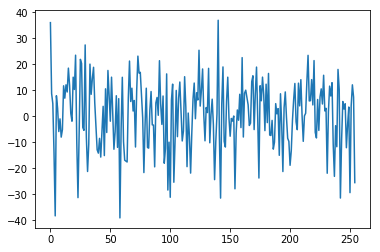

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(emphasized_signal)

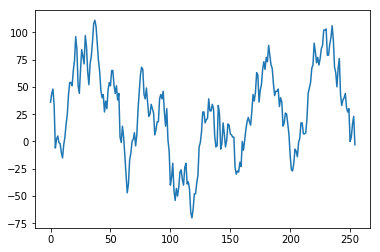

In [7]:
plt.plot(signal)

## 计算短时能量

In [8]:
import wave
f= wave.open(r"C:\Users\Administrator\Desktop\端点检测\lab1\语料\1.wav")
params = f.getparams()
# nframes 采样点数目
nchannels, sampwidth, framerate, nframes = params[:4]
# readframes() 按照采样点读取数据
str_data = f.readframes(nframes)            # str_data 是二进制字符串
# 转成二字节数组形式（每个采样点占两个字节）
wave_data = np.fromstring(str_data, dtype = np.short)
print( "采样点数目：" + str(len(wave_data)))          #输出应为采样点数目
f.close()

采样点数目：43933


In [9]:
#计算短时能量的函数
# 计算每一帧的能量 256个采样点为一帧
def calEnergy(wave_data) :
    energy = []
    sum = 0
    for i in range(len(wave_data)) :
        sum = sum + (int(wave_data[i]) * int(wave_data[i]))
        if (i + 1) % 256 == 0 :
            energy.append(sum)
            sum = 0
        elif i == len(wave_data) - 1 :
            energy.append(sum)
    return energy

In [10]:
energy = calEnergy(wave_data)

In [11]:
len(energy)

172

In [12]:
# 自定义函数，计算数值的符号。
def sgn(data):
    if data >= 0 :
        return 1
    else :
        return 0
#计算过零率
def calZeroCrossingRate(wave_data) :
    zeroCrossingRate = []
    sum = 0
    for i in range(len(wave_data)) :
        if i % 256 == 0:
            continue
        sum = sum + np.abs(sgn(wave_data[i]) - sgn(wave_data[i - 1]))
        if (i + 1) % 256 == 0 :
            zeroCrossingRate.append(float(sum) / 255)
            sum = 0
        elif i == len(wave_data) - 1 :
            zeroCrossingRate.append(float(sum) / 255)
    return zeroCrossingRate

In [13]:
zeroCrossingRate = calZeroCrossingRate(wave_data)

In [14]:
len(zeroCrossingRate)

172

## 双门限法端点检测 

In [15]:
# 利用短时能量，短时过零率，使用双门限法进行端点检测
def endPointDetect(wave_data, energy, zeroCrossingRate) :
    sum = 0
    energyAverage = 0
    for en in energy :
        sum = sum + en
    energyAverage = sum / len(energy)

    sum = 0
    for en in energy[:5] :
        sum = sum + en
    ML = sum / 5                        
    MH = energyAverage / 4              #较高的能量阈值
    ML = (ML + MH) / 4    #较低的能量阈值
    sum = 0
    for zcr in zeroCrossingRate[:5] :
        sum = float(sum) + zcr             
    Zs = sum / 5                     #过零率阈值

    A = []
    B = []
    C = []

    # 首先利用较大能量阈值 MH 进行初步检测
    flag = 0
    for i in range(len(energy)):
        if len(A) == 0 and flag == 0 and energy[i] > MH :
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 > A[len(A) - 1]:
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 <= A[len(A) - 1]:
            A = A[:len(A) - 1]
            flag = 1

        if flag == 1 and energy[i] < MH :
            A.append(i)
            flag = 0
#     print("较高能量阈值，计算后的浊音A:" + str(A))

    # 利用较小能量阈值 ML 进行第二步能量检测
    for j in range(len(A)) :
        i = A[j]
        if j % 2 == 1 :
            while i < len(energy) and energy[i] > ML :
                i = i + 1
            B.append(i)
        else :
            while i > 0 and energy[i] > ML :
                i = i - 1
            B.append(i)
#     print("较低能量阈值，增加一段语言B:" + str(B))

    # 利用过零率进行最后一步检测
    for j in range(len(B)) :
        i = B[j]
        if j % 2 == 1 :
            while i < len(zeroCrossingRate) and zeroCrossingRate[i] >= 3 * Zs :
                i = i + 1
            C.append(i)
        else :
            while i > 0 and zeroCrossingRate[i] >= 3 * Zs :
                i = i - 1
            C.append(i)
#     print("过零率阈值，最终语音分段C:" + str(C))
    return C


In [16]:
res= endPointDetect(wave_data,energy,zeroCrossingRate)

In [17]:
res

[85, 164]

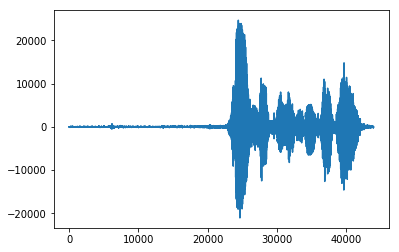

In [18]:
plt.plot(wave_data)

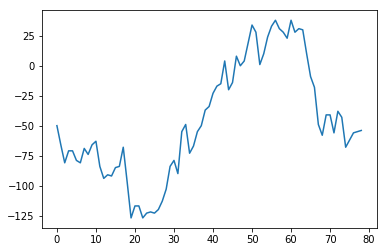

In [20]:
plt.plot(wave_data[85:164])

In [22]:
with open("test.pcm",'wb') as f:
    i=0 
    while i<len(res):
        for num in wave_data[res[i]*256:res[i+1]*256]:
            f.write(num)
        i=i+2

In [24]:
import wave
import numpy as np
import matplotlib.pyplot as plt

def read(data_path):
    '''读取语音信号
    '''
    wavepath = data_path
    f = wave.open(wavepath,'rb')
    params = f.getparams()
    nchannels,sampwidth,framerate,nframes = params[:4] #声道数、量化位数、采样频率、采样点数
    str_data = f.readframes(nframes) #读取音频，字符串格式
    f.close()
    wavedata = np.fromstring(str_data,dtype = np.short) #将字符串转化为浮点型数据
    wavedata = wavedata * 1.0 / (max(abs(wavedata))) #wave幅值归一化
    return wavedata,nframes,framerate

def plot(data,time):
    plt.plot(time,data)
    plt.grid('on')
    plt.show()

def enframe(data,win,inc):
    '''对语音数据进行分帧处理
    input:data(一维array):语音信号
          wlen(int):滑动窗长
          inc(int):窗口每次移动的长度
    output:f(二维array)每次滑动窗内的数据组成的二维array
    '''
    nx = len(data) #语音信号的长度
    try:
        nwin = len(win)
    except Exception as err:
        nwin = 1	
    if nwin == 1:
        wlen = win
    else:
        wlen = nwin
    nf = int(np.fix((nx - wlen) / inc) + 1) #窗口移动的次数
    f = np.zeros((nf,wlen))  #初始化二维数组
    indf = [inc * j for j in range(nf)]
    indf = (np.mat(indf)).T
    inds = np.mat(range(wlen))
    indf_tile = np.tile(indf,wlen)
    inds_tile = np.tile(inds,(nf,1))
    mix_tile = indf_tile + inds_tile
    f = np.zeros((nf,wlen))
    for i in range(nf):
        for j in range(wlen):
            f[i,j] = data[mix_tile[i,j]]
    return f

def point_check(wavedata,win,inc):
    '''语音信号端点检测
    input:wavedata(一维array)：原始语音信号
    output:StartPoint(int):起始端点
           EndPoint(int):终止端点
    '''
    #1.计算短时过零率
    FrameTemp1 = enframe(wavedata[0:-1],win,inc)
    FrameTemp2 = enframe(wavedata[1:],win,inc)
    signs = np.sign(np.multiply(FrameTemp1,FrameTemp2)) # 计算每一位与其相邻的数据是否异号，异号则过零
    signs = list(map(lambda x:[[i,0] [i>0] for i in x],signs))
    signs = list(map(lambda x:[[i,1] [i<0] for i in x], signs))
    diffs = np.sign(abs(FrameTemp1 - FrameTemp2)-0.01)
    diffs = list(map(lambda x:[[i,0] [i<0] for i in x], diffs))
    zcr = list((np.multiply(signs, diffs)).sum(axis = 1))
    #2.计算短时能量
    amp = list((abs(enframe(wavedata,win,inc))).sum(axis = 1))
#    # 设置门限
#    print('设置门限')
    ZcrLow = max([round(np.mean(zcr)*0.1),3])#过零率低门限
    ZcrHigh = max([round(max(zcr)*0.1),5])#过零率高门限
    AmpLow = min([min(amp)*10,np.mean(amp)*0.2,max(amp)*0.1])#能量低门限
    AmpHigh = max([min(amp)*10,np.mean(amp)*0.2,max(amp)*0.1])#能量高门限
    # 端点检测
    MaxSilence = 8 #最长语音间隙时间
    MinAudio = 16 #最短语音时间
    Status = 0 #状态0:静音段,1:过渡段,2:语音段,3:结束段
    HoldTime = 0 #语音持续时间
    SilenceTime = 0 #语音间隙时间
    print('开始端点检测')
    StartPoint = 0
    for n in range(len(zcr)):
        if Status ==0 or Status == 1:
            if amp[n] > AmpHigh or zcr[n] > ZcrHigh:
                StartPoint = n - HoldTime
                Status = 2
                HoldTime = HoldTime + 1
                SilenceTime = 0
            elif amp[n] > AmpLow or zcr[n] > ZcrLow:
                Status = 1
                HoldTime = HoldTime + 1
            else:
                Status = 0
                HoldTime = 0
        elif Status == 2:
            if amp[n] > AmpLow or zcr[n] > ZcrLow:
                HoldTime = HoldTime + 1
            else:
                SilenceTime = SilenceTime + 1
                if SilenceTime < MaxSilence:
                    HoldTime = HoldTime + 1
                elif (HoldTime - SilenceTime) < MinAudio:
                    Status = 0
                    HoldTime = 0
                    SilenceTime = 0
                else:
                    Status = 3
        elif Status == 3:
            break
        if Status == 3:
            break
    HoldTime = HoldTime - SilenceTime
    EndPoint = StartPoint + HoldTime
    return StartPoint,EndPoint,FrameTemp1
   



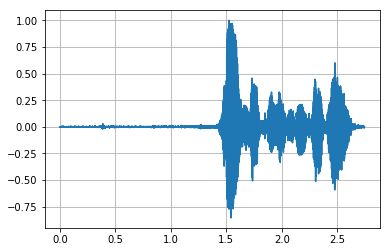

开始端点检测


NameError: name 'check_signal' is not defined

In [25]:
data_path = r'C:\Users\Administrator\Desktop\端点检测\lab1\语料\1.wav'
win = 240
inc = 80
wavedata,nframes,framerate = read(data_path)
time_list = np.array(range(0,nframes)) * (1.0 / framerate)
plot(wavedata,time_list)
StartPoint,EndPoint,FrameTemp = point_check(wavedata,win,inc)
checkdata,Framecheck = check_signal(StartPoint,EndPoint,FrameTemp,win,inc)


In [26]:
StartPoint

274

In [27]:
EndPoint

529

In [29]:
len(FrameTemp)

547

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import volume as vp
import sounddevice as sd
import math
def simpleEndPointDetection(vol,wave: vp.Wave):
    # threshold1 = np.max(vol) * 0.10
    # threshold2 = np.min(vol) * 10.0
    # threshold3 = np.max(vol) * 0.05 + np.min(vol) * 5.0
    vmax = np.max(vol)
    vmin = np.min(vol)
    vdiff = vmax - vmin
    # 给出三个固定的阈值
    threshold1 = vmin + vdiff * 0.20
    threshold2 = vmin + vdiff * 0.10
    threshold3 = vmin + vdiff * 0.15
    deltatime = wave.deltatime
    frame = np.arange(0, len(vol)) * deltatime

    # 分别找出三个不同的阈值
    index1 = vp.findIndex(vol, threshold1) * deltatime
    index2 = vp.findIndex(vol, threshold2) * deltatime
    index3 = vp.findIndex(vol, threshold3) * deltatime
    end = len(wave.ws) * (1.0 / wave.framerate)

    plt.subplot(211)
    plt.plot(wave.ts,wave.ws,color="black")
    if len(index1) > 0:
        plt.plot([index1,index1],[-1,1],'-r')
    if len(index2) > 0:
        plt.plot([index2,index2],[-1,1],'-g')
    if len(index3) > 0:
        plt.plot([index3,index3],[-1,1],'-b')
    plt.ylabel('Amplitude')

    plt.subplot(212)
    plt.plot(frame, vol, color="black")
    if len(index1) > 0:
        plt.plot([0,end],[threshold1,threshold1],'-r', label="threshold 1")
    if len(index2) > 0:
        plt.plot([0,end],[threshold2,threshold2],'-g', label="threshold 2")
    if len(index3) > 0:
        plt.plot([0,end],[threshold3,threshold3],'-b', label="threshold 3")
    plt.legend()
    plt.ylabel('Volume(absSum)')
    plt.xlabel('time(seconds)')
    plt.show()

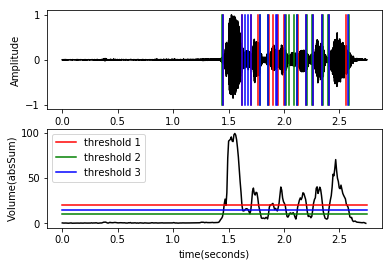

In [40]:
one = vp.readFile(r"C:\Users\Administrator\Desktop\端点检测\lab1\语料\1.wav", dtype=np.int)
vol = one.normalVolume()
simpleEndPointDetection(vol, one)